### Project 3: Plausible Utopia 

### Classification Modeling on Subreddits to Classify Futurists vs. Scientists

#### Libary imports

In [304]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
     
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from sklearn.feature_extraction.text import CountVectorizer
import string


import warnings; warnings.simplefilter('ignore')
##this will hide deprecation/future warnings

from IPython.display import Markdown, display
pd.set_option('display.max_row', 200) # Set ipython's max row display
pd.set_option('display.max_columns', 85) # Set iPython's max column count
pd.set_option('display.max_colwidth', 1_000) # Set iPython's max column width

# pseudo-markdown in code cells
def printmd(string):
    display(Markdown(string))
# ref: https://discuss.analyticsvidhya.com/t/how-to-make-a-text-bold-within-print-statement-in-ipython-notebook/14552/2

#### Data collection

I utilized the Python Reddit API Wrapper (PRAW) API in the data collection process. You can find the steps I took in the `PRAW_data_collection` notebook, located in the code folder of this repository.

The East Coast local instructors were very generous with their walkthrough of the process, so I definitely credit them for the ease of the data collection.

From [rubric](https://git.generalassemb.ly/abishop17/project_3/blob/master/README.md):

>Was data collection and storage optimized through custom functions, pipelines, and/or automation? <br><br>
>Was thought given to the server receiving the requests such as considering number of requests per second?

#### Preprocessing and EDA

In [305]:
subred1 = pd.read_csv('../data/df_with_both_subs.csv', index_col = 'id')
subred1 = subred1.drop(columns = 'Unnamed: 0')
display(pd.set_option('display.max_colwidth', 50), subred1.head())

None

,title,score,url,comms_num,created,body,subreddit
id,,,,,,,
japxs3,What would the point be to do anything if AI c...,0,https://www.reddit.com/r/Futurology/comments/j...,4,1.602664e+09,The more I look into AI and new projects like ...,futurology
japq75,ELCC Explained: the Critical Renewable Energy ...,4,https://blog.ucsusa.org/mark-specht/elcc-expla...,0,1.602663e+09,NaN,futurology
jaojnb,There's a 50-50 chance we're living in a simul...,8,https://boingboing.net/2020/10/13/new-research...,4,1.602659e+09,NaN,futurology
jaofpy,"Eight nations sign NASA's Artemis Accords, ple...",3,https://www.engadget.com/nasa-artemis-accords-...,1,1.602658e+09,NaN,futurology
jaocqq,Mercedes benz AVTR - In Action,8,https://www.youtube.com/watch?v=ChqM3zqTREQ&ab...,0,1.602658e+09,NaN,futurology


---

In [306]:
printmd('**Value counts:**')
display(subred1['subreddit'].value_counts())

printmd('**Value counts by weight:**')
subred1['subreddit'].value_counts(normalize = True)

**Value counts:**

science       931
futurology    869
Name: subreddit, dtype: int64

**Value counts by weight:**

science       0.517222
futurology    0.482778
Name: subreddit, dtype: float64

* I may want to return to the subreddits to get a bigger dataset to work with. 

* The classes are slightly unbalanced, so that will be a consideration during the preprocessing / get-more-data phase.

In [307]:
subred1[['title', 'subreddit']]

,title,subreddit
id,,
japxs3,What would the point be to do anything if AI c...,futurology
japq75,ELCC Explained: the Critical Renewable Energy ...,futurology
jaojnb,There's a 50-50 chance we're living in a simul...,futurology
jaofpy,"Eight nations sign NASA's Artemis Accords, ple...",futurology
jaocqq,Mercedes benz AVTR - In Action,futurology
...,...,...
ir136p,Adults with positive SARS-CoV-2 test results w...,science
ir0vem,50% of Phosphorus Lost to Erosion,science
ir0pvm,Motivated Helplessness in the Context of the C...,science


In [308]:
# Null body rows
printmd(f"**Only {len(subred1['body'][(subred1['body'].isnull()).astype(int) == 0])} non-null `body` records.**")

non_null_body = subred1[['body', 'subreddit']][(subred1['body'].isnull()).astype(int) == 0]

**Only 69 non-null `body` records.**

In [309]:
# Check out the non-null body text

display(non_null_body.head())

printmd('<br>')

display(non_null_body.tail())

,body,subreddit
id,,
japxs3,The more I look into AI and new projects like ...,futurology
jamgnw,As our dependence on computer technologies inc...,futurology
jag7ht,Please post all climate change news here unles...,futurology
ja7ygc,Is there any effort by others to bring the oth...,futurology
ja5exx,Everyday we're learing more efficient ways to ...,futurology


<br>

,body,subreddit
id,,
izivy1,To create the most imersive experiences in a v...,futurology
j9s11j,The Sveriges Riksbank Prize in Economic Scienc...,science
j6qfra,The Nobel Prize in Chemistry 2020 was awarded ...,science
j64fiy,"The Nobel Prize in Physics 2020 was divided, o...",science
j5jyd0,The Nobel Prize in Physiology or Medicine 2020...,science


In [310]:
printmd('**Can we get enough content from post titles?**')

**Can we get enough content from post titles?**

---

#### NLP EDA

In [311]:
display(pd.set_option('display.max_colwidth', 1_000), subred1[['title', 'body']])

None

,title,body
id,,
japxs3,What would the point be to do anything if AI could just do it all for us?,"The more I look into AI and new projects like GPT-3, we humans suck. Sure GPT-3 isn't on the level as a human brain, but that doesn't mean gpt-4 or gpt-5 won't be. I can already see the massive jobs loss as AI will offset more jobs than it will create. I'm just feeling a little existential crisis here"
japq75,"ELCC Explained: the Critical Renewable Energy Concept You’ve Never Heard Of ""Now we live in a day and age where some parts of the country generate more than 30% of their electricity with variable renewables, and that number will fast approach 100% in the decades to come.""",NaN
jaojnb,"There's a 50-50 chance we're living in a simulation and here's how to find out ""the probability will increase as we develop technology enabling the creation of a simulation containing conscious beings.""",NaN
jaofpy,"Eight nations sign NASA's Artemis Accords, pledging peace on the moon ""It's a reaffirmation of the 1967 Outer Space Treaty.""",NaN
jaocqq,Mercedes benz AVTR - In Action,NaN
...,...,...
ir136p,Adults with positive SARS-CoV-2 test results were approximately twice as likely to have reported dining at a restaurant than were those with negative SARS-CoV-2 test results.,NaN
ir0vem,50% of Phosphorus Lost to Erosion,NaN
ir0pvm,Motivated Helplessness in the Context of the Covid-19 Pandemic: Evidence for a Curvilinear Relationship Between Perceived Ability to Avoid the Virus and Anxiety,NaN


In [312]:
stemmer = PorterStemmer()  #instantiate stemmer

def split_and_stem(string):
    word = ""   #empty string
    string = string.split(' ') #creates list of words
    for i in string: #iterates through that list of words
        word += (stemmer.stem(i) + " ")  #stems each word and adds to empty string
    return word  #returns string with stemmed words

In [313]:
subred1['title'] = subred1['title'].apply(split_and_stem)

In [314]:
subred1['title'].head()

id
japxs3                                                                                                                                                                                           what would the point be to do anyth if AI could just do it all for us? 
japq75    elcc explained: the critic renew energi concept you’v never heard Of "now we live in a day and age where some part of the countri gener more than 30% of their electr with variabl renewables, and that number will fast approach 100% in the decad to come." 
jaojnb                                                                                    there' a 50-50 chanc we'r live in a simul and here' how to find out "the probabl will increas as we develop technolog enabl the creation of a simul contain consciou beings." 
jaofpy                                                                                                                                                  eight nation sign nasa' artemi accords, pledg peac

In [315]:
# Check the balance of classes

subred1['subreddit'].value_counts(normalize = True)

science       0.517222
futurology    0.482778
Name: subreddit, dtype: float64

#### Binarize target feature

In [316]:
display(subred1['subreddit'].value_counts())

subred1['subreddit'] = subred1['subreddit'].map({'science': 1, 'futurology': 0})

display(subred1['subreddit'].value_counts())

science       931
futurology    869
Name: subreddit, dtype: int64

1    931
0    869
Name: subreddit, dtype: int64

#### Set features

In [317]:
# Set feature matrix and target variable

X = subred1['title']
y = subred1['subreddit']

### Cutoff point 

#### To toggle between Option 1 (EDA)  and Option 2 (Optimal modeling) below:
**Step 1**: Click on this cell, then select the following from the Jupyter Notebook menu:  `Cell`  > `Run all above`

**Step 2**: Run the cells within each section below

**Step 3**: After running the last cell within the section, repeat `Step 1`, and go to the next section 

---

### Option 1: Implement CountVectorizer right away for purposes of EDA

### Preprocessing
- Remove special characters
- Tokenize
- Lemmatize / stem
- Remove stop words

#### CountVectorizer

1. Count number of times a token is observed in a given subreddit post

2. Create a vector to store those counts

In [285]:
len(cvec.get_feature_names())

6364

In [286]:
# Instantiate CountVectorizer 

cvec = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on the corpus
X = cvec.fit_transform(X)

printmd('**Size of feature matrix:**')
display(X.shape)

printmd('**Have a look at random slices of our tokens:**')
for i in np.arange(0, len(cvec.get_feature_names()), step = 1000):
    increment = 20
    print('\n', cvec.get_feature_names()[i: i + increment])

**Size of feature matrix:**

(1800, 6364)

**Have a look at random slices of our tokens:**


 ['000', '01', '012', '026', '061', '083', '10', '100', '1000', '1000x', '100m', '1010g', '1062', '107', '10g', '10gw', '10th', '11', '113', '114']

 ['capac', 'capacity', 'cape', 'capit', 'capita', 'capitalism', 'capitalist', 'capsid', 'capsul', 'capsule', 'captur', 'capture', 'car', 'carbohydr', 'carbon', 'carboxyl', 'carboxymethyl', 'carcinoma', 'cardiac', 'cardiolog']

 ['encrypt', 'encycl', 'end', 'endang', 'endless', 'endocanabinoids', 'endocannabinoids', 'endogen', 'endors', 'energi', 'energy', 'enforc', 'enforced', 'engag', 'engagement', 'engin', 'engine', 'engineering', 'england', 'english']

 ['infrastructur', 'infus', 'ingest', 'ingredi', 'inhal', 'inher', 'inherit', 'inhibit', 'inhibitor', 'initi', 'initiation', 'inject', 'injuri', 'injuries', 'injury', 'ink', 'inner', 'innov', 'innovation', 'innovations']

 ['ny', 'nyc', 'nylon', 'oae2', 'obamacare', 'obes', 'obese', 'obesity', 'object', 'obligations', 'observ', 'observatori', 'obstruct', 'obtain', 'occasion', 'occup', 'o

In [287]:
# Convert training data to dataframe
X = pd.DataFrame(X.todense(), columns = cvec.get_feature_names())

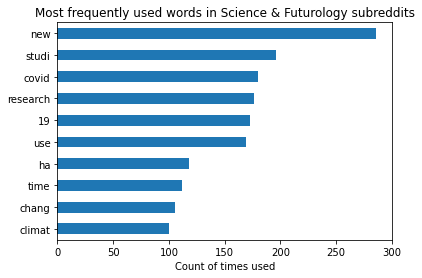

In [288]:
# Plot top occurring words
X.sum().sort_values(ascending = False).head(10)[::-1].plot(kind = 'barh')

plt.title('Most frequently used words in Science & Futurology subreddits')
plt.xlabel('Count of times used');

### Option 2: Identify an optimal model with a pipeline and GridSearch

<br>

### Train-test split

In [318]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.33,
                                                    stratify = y,
                                                    random_state = 42)

In [319]:
display(X_train.shape)
display(y_train.shape)

(1206,)

(1206,)

#### Build a pipeline

* CountVectorizer + LogisticRegression

* CountVectorizer + RandomForest

In [340]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe_cvec_nb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())    # Naive Bayes
])

# Let's set another pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. LogisticRegression (estimator)

pipe_log_reg = Pipeline([
    ('cvec', CountVectorizer()),
    ('log_reg', LogisticRegression())
])

In [342]:
# Search over the following values of hyperparameters:
# Maximum number of features fit
# Minimum number of documents needed to include token
# Maximum number of documents needed to include token
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_cvec_nb_params = {
    'cvec__max_features': [1_000, 2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.98, .99],
    'cvec__ngram_range': [(1,1), (1,2)]
}

# Instantiate GridSearchCV.

gs_cvec_nb = GridSearchCV(pipe_cvec_nb, # what object are we optimizing?
                  param_grid = pipe_cvec_nb_params, # what parameters values are we searching?
                  cv=5)      # 5-fold cross-validation.
#                  verbose=1) 

In [344]:
# Fit GridSearch to data.
gs_cvec_nb.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.98, 0.99],
                         'cvec__max_features': [1000, 2000, 3000, 4000, 5000],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [345]:
# What's the best score?
printmd(f'**Best score**: {round(gs_cvec_nb.best_score_, 4)}')

# Score model on train set.
printmd(f'**R2 score on train set**: {round(gs_cvec_nb.score(X_train, y_train), 4)}')

# Score model on test set.
printmd(f'**R2 score on test set**: {round(gs_cvec_nb.score(X_test, y_test), 4)}')

**Best score**: 0.8389

**R2 score on train set**: 0.9179

**R2 score on test set**: 0.9226

#### Logistic classification model with ridge regularization

In [170]:
# Instantiate the model 




ValueError: could not convert string to float: 'what would the point be to do anyth if AI could just do it all for us? '

In [169]:
cross_val_score(ridge_model_1, X, y)

array([nan, nan, nan, nan, nan])

**Ignore `body` column since there are so few in the dataset.**

In [136]:
# subred1['title_sent_tokens'] = subred1['title'].apply(lambda x: sent_tokenize(x))
# subred1['title_sent_tokens'] = pd.DataFrame(subred1['title_sent_tokens'])

# # Instantiate RegExp Tokenizer
# tokenizer = RegexpTokenizer(r'\w+')

# # "Run" Tokenizer
# # subred1_tokens = 
# subred1['title_sent_tokens'].apply(lambda x: tokenizer.tokenize(x))

# # subred1['title']

#### Models

NOT KNN !!

1. Logistic Regression or something else

2. Random Forest

In [ ]:
Train test split  : stratifying is important
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)